In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50


2024-04-27 14:11:43.505148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 14:11:43.505237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 14:11:43.541987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 14:11:43.631550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 14:11:44.747166: W tensorflow/compiler/tf2

In [2]:
# Define the paths to your dataset
train_dir = '/home/alienblade/College Stuff/Workspace/AI/Master Folder/train'
validation_dir = '/home/alienblade/College Stuff/Workspace/AI/Master Folder/valid'
test_dir = '/home/alienblade/College Stuff/Workspace/AI/Master Folder/test'
# Define image dimensions
img_height = 150
img_width = 150
batch_size = 32

In [3]:
# Use ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Load and preprocess the dataset
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_data = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [5]:
# Load the pre-trained ResNet50 model without the top layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add your custom top layer for classification
x = GlobalAveragePooling2D()(base_model_resnet.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

2024-04-27 14:12:00.032677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 14:12:00.294422: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# Create the model
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model_resnet.layers:
    layer.trainable = False

In [7]:
#Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Train the model
history_resnet = model_resnet.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=10,
    validation_data=validation_data,
    validation_steps=validation_data.samples // batch_size
)

Epoch 1/10
31/31 [==============================] - 22s 618ms/step - loss: 1.4182 - accuracy: 0.2614 - val_loss: 1.4459 - val_accuracy: 0.2500
Epoch 2/10
31/31 [==============================] - 18s 560ms/step - loss: 1.4082 - accuracy: 0.2562 - val_loss: 1.3378 - val_accuracy: 0.3438
Epoch 3/10
31/31 [==============================] - 20s 630ms/step - loss: 1.3921 - accuracy: 0.2645 - val_loss: 1.3823 - val_accuracy: 0.1562
Epoch 4/10
31/31 [==============================] - 19s 610ms/step - loss: 1.3805 - accuracy: 0.2924 - val_loss: 1.3288 - val_accuracy: 0.4375
Epoch 5/10
31/31 [==============================] - 19s 611ms/step - loss: 1.3882 - accuracy: 0.2593 - val_loss: 1.3320 - val_accuracy: 0.4375
Epoch 6/10
31/31 [==============================] - 19s 607ms/step - loss: 1.3763 - accuracy: 0.2810 - val_loss: 1.3192 - val_accuracy: 0.4375
Epoch 7/10
31/31 [==============================] - 19s 608ms/step - loss: 1.3927 - accuracy: 0.2614 - val_loss: 1.3548 - val_accuracy: 0.3438

Graphs

Found 38 images belonging to 4 classes.
2/2 [==============================] - 1s 89ms/step


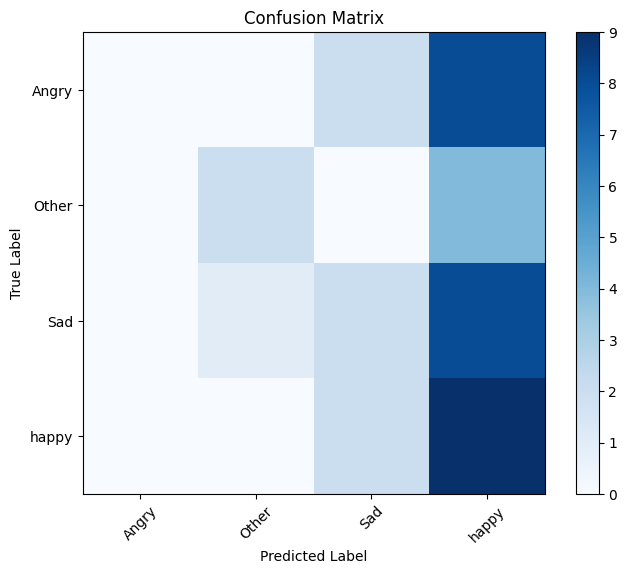

In [20]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
model = load_model('pec_res.h5')

# Use ImageDataGenerator for data preprocessing (no augmentation for test data)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the test dataset
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep data in the same order as labels
)

# Make predictions on the test dataset
y_pred = model.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels from the test dataset
true_labels = test_data.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_data.class_indices))
plt.xticks(tick_marks, test_data.class_indices, rotation=45)
plt.yticks(tick_marks, test_data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


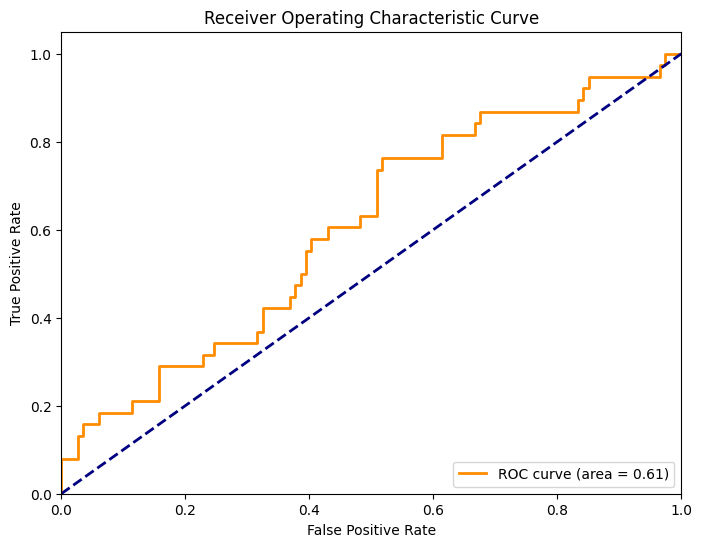

Found 38 images belonging to 4 classes.
2/2 [==============================] - 1s 94ms/step


NameError: name 'interp1d' is not defined

In [23]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Convert multiclass labels to binary labels
lb = LabelBinarizer()
true_labels_bin = lb.fit_transform(true_labels)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()
# Load the saved model
model = load_model('pec_res.h5')

# Use ImageDataGenerator for data preprocessing (no augmentation for test data)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the test dataset
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep data in the same order as labels
)

# Make predictions on the test dataset
y_pred = model.predict(test_data)

# Get the true labels from the test dataset
true_labels = test_data.classes

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# Interpolate the ROC curve for smoother plotting
fpr_interp = np.linspace(0, 1, 100)
tpr_interp = interp1d(fpr, tpr)(fpr_interp)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_interp, tpr_interp, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


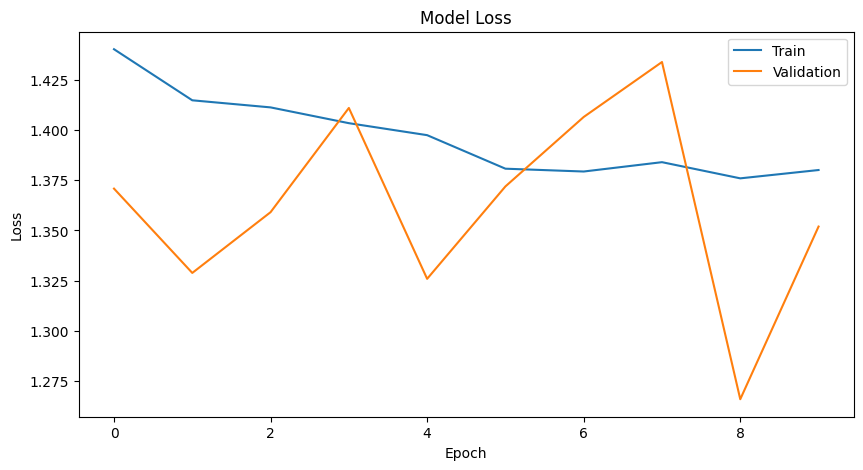

In [25]:

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

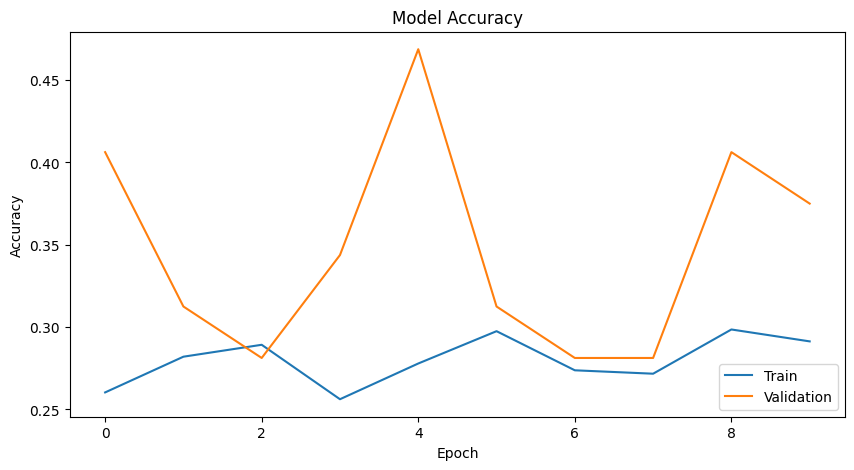

In [17]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
